In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats

# Load the cleaned dataset
data = pd.read_csv('cleaned_student_data2.csv')

# Define the target and features
target = 'G3'
features = data.drop(columns=[target])
sensitive_features = ['age', 'Dalc']

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['G3_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive features
data['age_bin'] = pd.cut(data['age'], bins=5, labels=False)
data['Dalc_bin'] = pd.cut(data['Dalc'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, data['G3_binary'], test_size=0.2, random_state=42)

# Reset indices to ensure alignment
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Base Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained base model
y_pred_binary = rf_model.predict(X_test)

# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

# Compute metrics for different groups for the base model
metrics_base = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, ['age_bin', 'Dalc_bin']]
)

# Print the overall metrics for the base model
print("Overall Metrics for Base Model:")
print(metrics_base.overall)

# Print metrics by sensitive feature groups for the base model
print("\nMetrics by Sensitive Feature Groups for Base Model:")
print(metrics_base.by_group)


Overall Metrics for Base Model:
{'accuracy': 0.8481012658227848, 'precision': 0.8125, 'recall': 0.9285714285714286, 'f1': 0.8666666666666667}

Metrics by Sensitive Feature Groups for Base Model:
age_bin  Dalc_bin
0        0           {'accuracy': 0.8524590163934426, 'precision': ...
         2           {'accuracy': 0.8, 'precision': 0.6666666666666...
         4           {'accuracy': 1.0, 'precision': 1.0, 'recall': ...
1        0           {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
         2                                                         NaN
         4                                                         NaN
Name: compute_metrics, dtype: object


In [3]:
# Custom Reweighing Function
def compute_sample_weights(X, y, sensitive_features):
    df = X.copy()
    df['y'] = y
    df['sensitive'] = sensitive_features
    # Calculate group counts
    group_counts = df.groupby('sensitive')['y'].count()
    group_positive_counts = df.groupby('sensitive')['y'].sum()
    group_negative_counts = group_counts - group_positive_counts
    # Calculate weights
    positive_weight = 1.0 / group_positive_counts
    negative_weight = 1.0 / group_negative_counts
    df['weight'] = df.apply(lambda row: positive_weight[row['sensitive']] if row['y'] == 1 else negative_weight[row['sensitive']], axis=1)
    return df['weight'].values

# Apply reweighing
sensitive_features_combined = data[['age_bin', 'Dalc_bin']].apply(lambda x: tuple(x), axis=1)
sample_weights = compute_sample_weights(X_train, y_train, sensitive_features_combined.loc[X_train.index])

# Train a Random Forest model with reweighed samples
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained reweighed model
y_pred_binary_rw = rf_model_rw.predict(X_test)

# Compute metrics for the reweighed model
metrics_rw = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary_rw,
    sensitive_features=data.loc[X_test.index, ['age_bin', 'Dalc_bin']]
)

# Print the overall metrics for the reweighed model
print("Overall Metrics for Reweighed Model:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups for the reweighed model
print("\nMetrics by Sensitive Feature Groups for Reweighed Model:")
print(metrics_rw.by_group)


Overall Metrics for Reweighed Model:
{'accuracy': 0.8987341772151899, 'precision': 0.84, 'recall': 1.0, 'f1': 0.9130434782608695}

Metrics by Sensitive Feature Groups for Reweighed Model:
age_bin  Dalc_bin
0        0           {'accuracy': 0.9016393442622951, 'precision': ...
         2           {'accuracy': 0.8666666666666667, 'precision': ...
         4           {'accuracy': 1.0, 'precision': 1.0, 'recall': ...
1        0           {'accuracy': 1.0, 'precision': 0.0, 'recall': ...
         2                                                         NaN
         4                                                         NaN
Name: compute_metrics, dtype: object


In [4]:
# Define custom fairness metric functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    return np.max(rates) - np.min(rates)


In [5]:
# Recompute fairness metrics for both models
dpd_base = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_base = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_base = false_positive_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
fnrd_base = false_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])
srd_base = selection_rate_difference(y_pred_binary, sensitive_features=data.loc[X_test.index, 'age_bin'])

dpd_rw = demographic_parity_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_rw = equalized_odds_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_rw = false_positive_rate_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
fnrd_rw = false_negative_rate_difference(y_test, y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])
srd_rw = selection_rate_difference(y_pred_binary_rw, sensitive_features=data.loc[X_test.index, 'age_bin'])

print(f"Demographic Parity Difference for Base Model: {dpd_base}")
print(f"Equalized Odds Difference for Base Model: {eod_base}")
print(f"False Positive Rate Difference for Base Model: {fprd_base}")
print(f"False Negative Rate Difference for Base Model: {fnrd_base}")
print(f"Selection Rate Difference for Base Model: {srd_base}")

print(f"Demographic Parity Difference for Reweighed Model: {dpd_rw}")
print(f"Equalized Odds Difference for Reweighed Model: {eod_rw}")
print(f"False Positive Rate Difference for Reweighed Model: {fprd_rw}")
print(f"False Negative Rate Difference for Reweighed Model: {fnrd_rw}")
print(f"Selection Rate Difference for Reweighed Model: {srd_rw}")


Demographic Parity Difference for Base Model: 0.6153846153846154
Equalized Odds Difference for Base Model: 0.9285714285714286
False Positive Rate Difference for Base Model: 0.25
False Negative Rate Difference for Base Model: nan
Selection Rate Difference for Base Model: 0.6153846153846154
Demographic Parity Difference for Reweighed Model: 0.6410256410256411
Equalized Odds Difference for Reweighed Model: 1.0
False Positive Rate Difference for Reweighed Model: 0.2222222222222222
False Negative Rate Difference for Reweighed Model: nan
Selection Rate Difference for Reweighed Model: 0.6410256410256411


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_13452\2121948550.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_13452\2121948550.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)


In [6]:
# Adversarial Debiasing
adv_model = LogisticRegression(solver='liblinear', random_state=42)
adv_debias = ExponentiatedGradient(adv_model, constraints=DemographicParity(), eps=0.01)
adv_debias.fit(X_train, y_train, sensitive_features=sensitive_features_combined.loc[X_train.index])
y_pred_adv = adv_debias.predict(X_test)

metrics_adv = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_adv,
    sensitive_features=data.loc[X_test.index, ['age_bin', 'Dalc_bin']]
)

# Function to filter out degenerate labels
def filter_degenerate_labels(X, y, sensitive_features):
    combined = pd.DataFrame({
        'X': list(X.values),
        'y': y,
        'sensitive_features': sensitive_features
    })
    grouped = combined.groupby('sensitive_features')['y'].nunique()
    valid_sensitive_features = grouped[grouped > 1].index
    filtered_combined = combined[combined['sensitive_features'].isin(valid_sensitive_features)]
    return (pd.DataFrame(filtered_combined['X'].tolist(), index=filtered_combined.index),
            filtered_combined['y'],
            filtered_combined['sensitive_features'])

X_train_filtered, y_train_filtered, sensitive_features_filtered = filter_degenerate_labels(X_train, y_train, sensitive_features_combined.loc[X_train.index])

# Post-processing using ThresholdOptimizer
post_proc = ThresholdOptimizer(estimator=rf_model, constraints="demographic_parity", prefit=True, predict_method='predict')
post_proc.fit(X_train_filtered, y_train_filtered, sensitive_features=sensitive_features_filtered.astype(str))
y_pred_post_proc = post_proc.predict(X_test, sensitive_features=data.loc[X_test.index, 'age_bin'].astype(str))

metrics_post_proc = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_post_proc,
    sensitive_features=data.loc[X_test.index, ['age_bin', 'Dalc_bin']]
)

# Recompute fairness metrics for all models
dpd_adv = demographic_parity_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_adv = equalized_odds_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_adv = false_positive_rate_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
fnrd_adv = false_negative_rate_difference(y_test, y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])
srd_adv = selection_rate_difference(y_pred_adv, sensitive_features=data.loc[X_test.index, 'age_bin'])

dpd_post_proc = demographic_parity_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
eod_post_proc = equalized_odds_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
fprd_post_proc = false_positive_rate_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
fnrd_post_proc = false_negative_rate_difference(y_test, y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])
srd_post_proc = selection_rate_difference(y_pred_post_proc, sensitive_features=data.loc[X_test.index, 'age_bin'])

# Summarize all fairness metrics for all models
summary_metrics_base = {
    'Demographic Parity Difference': dpd_base,
    'Equalized Odds Difference': eod_base,
    'False Positive Rate Difference': fprd_base,
    'False Negative Rate Difference': fnrd_base,
    'Selection Rate Difference': srd_base
}

summary_metrics_rw = {
    'Demographic Parity Difference': dpd_rw,
    'Equalized Odds Difference': eod_rw,
    'False Positive Rate Difference': fprd_rw,
    'False Negative Rate Difference': fnrd_rw,
    'Selection Rate Difference': srd_rw
}

summary_metrics_adv = {
    'Demographic Parity Difference': dpd_adv,
    'Equalized Odds Difference': eod_adv,
    'False Positive Rate Difference': fprd_adv,
    'False Negative Rate Difference': fnrd_adv,
    'Selection Rate Difference': srd_adv
}

summary_metrics_post_proc = {
    'Demographic Parity Difference': dpd_post_proc,
    'Equalized Odds Difference': eod_post_proc,
    'False Positive Rate Difference': fprd_post_proc,
    'False Negative Rate Difference': fnrd_post_proc,
    'Selection Rate Difference': srd_post_proc
}

# Compare results of all models
comparison_all = pd.DataFrame({
    'Metric': ['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'],
    'Base Model': [dpd_base, eod_base, fprd_base, fnrd_base, srd_base],
    'Reweighed Model': [dpd_rw, eod_rw, fprd_rw, fnrd_rw, srd_rw],
    'Adversarial Debiasing Model': [dpd_adv, eod_adv, fprd_adv, fnrd_adv, srd_adv],
    'Post-Processing Model': [dpd_post_proc, eod_post_proc, fprd_post_proc, fnrd_post_proc, srd_post_proc]
})

print("\nComparison of Fairness Metrics between all Models:")
print(comparison_all)


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s


Comparison of Fairness Metrics between all Models:
                           Metric  Base Model  Reweighed Model  \
0   Demographic Parity Difference    0.615385         0.641026   
1       Equalized Odds Difference    0.928571         1.000000   
2  False Positive Rate Difference    0.250000         0.222222   
3  False Negative Rate Difference         NaN              NaN   
4       Selection Rate Difference    0.615385         0.641026   

   Adversarial Debiasing Model  Post-Processing Model  
0                     0.628205                    0.0  
1                     0.928571                    0.0  
2                     0.277778                    0.0  
3                          NaN                    NaN  
4                     0.628205                    0.0  


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_13452\2121948550.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)
C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_13452\2121948550.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  return fn / (fn + tp)


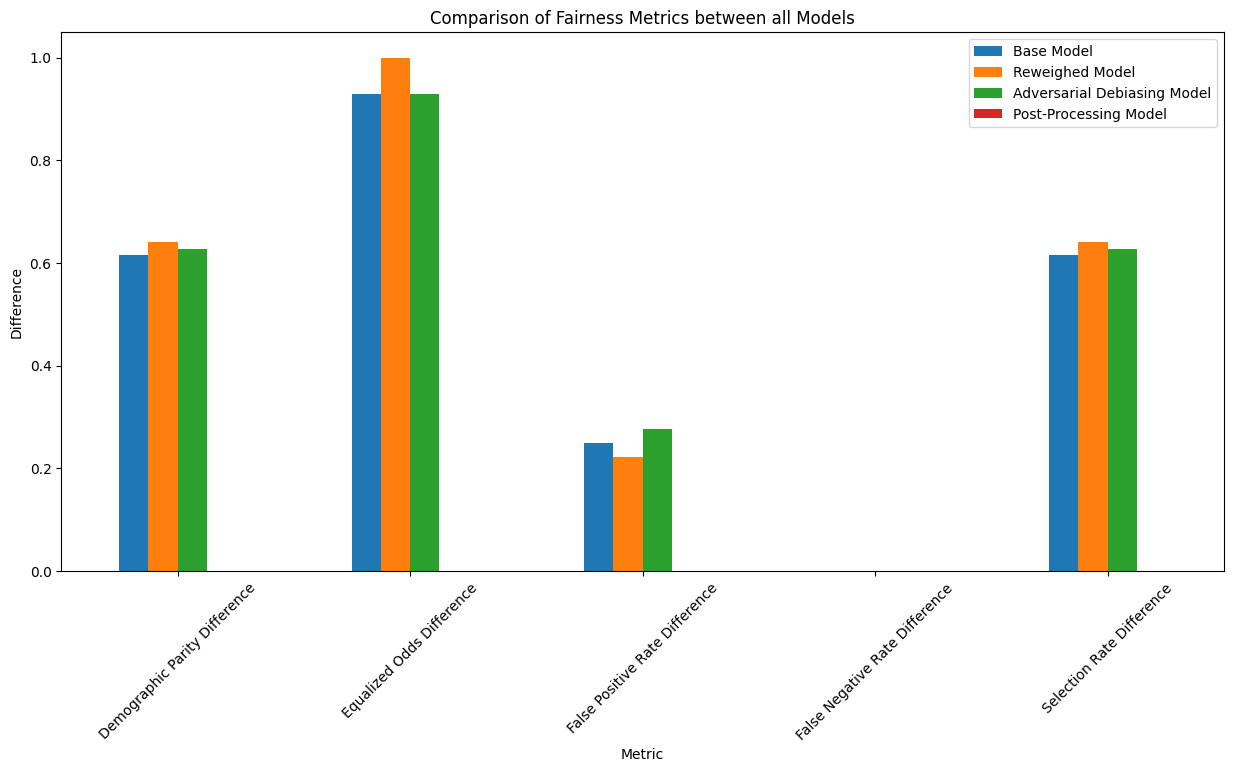

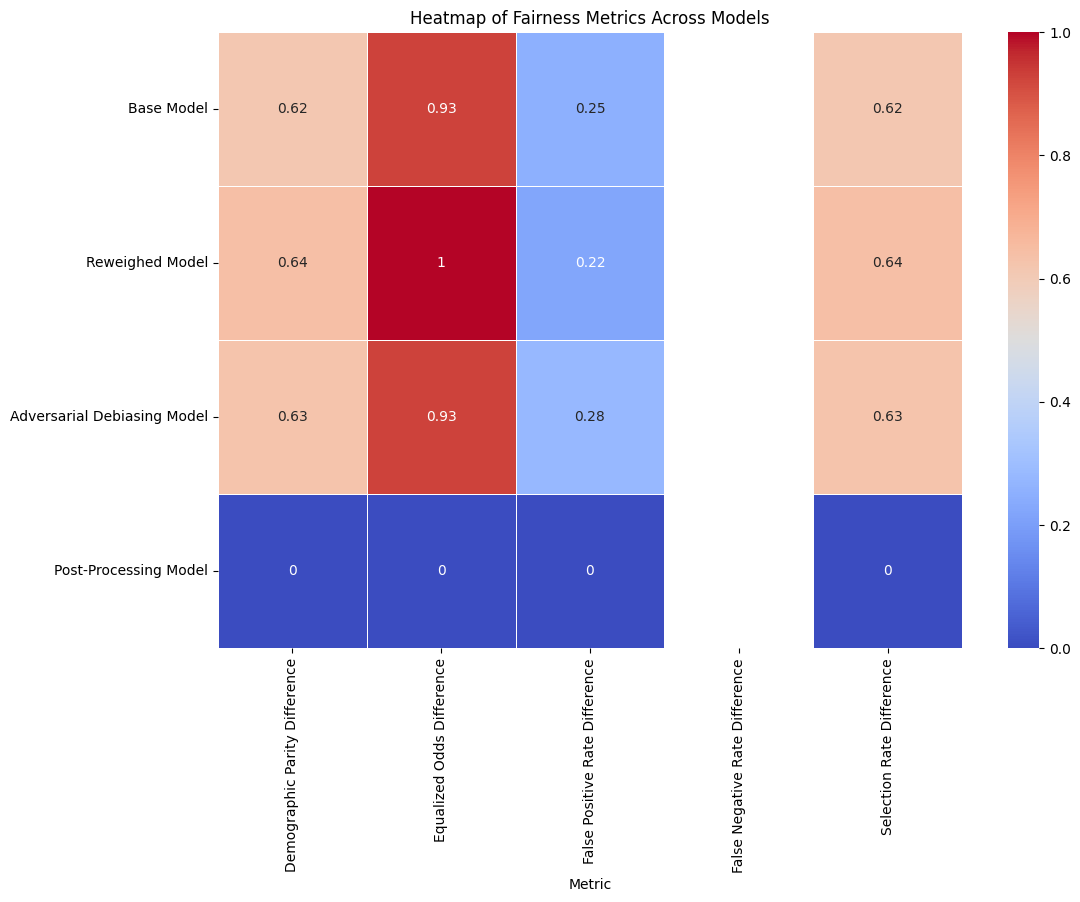

In [7]:
# Plot comparison of fairness metrics
comparison_all.set_index('Metric').plot(kind='bar', figsize=(15, 7))
plt.title('Comparison of Fairness Metrics between all Models')
plt.ylabel('Difference')
plt.xticks(rotation=45)
plt.show()

# Prepare data for heatmap
heatmap_data = comparison_all.set_index('Metric').transpose()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Fairness Metrics Across Models')
plt.show()


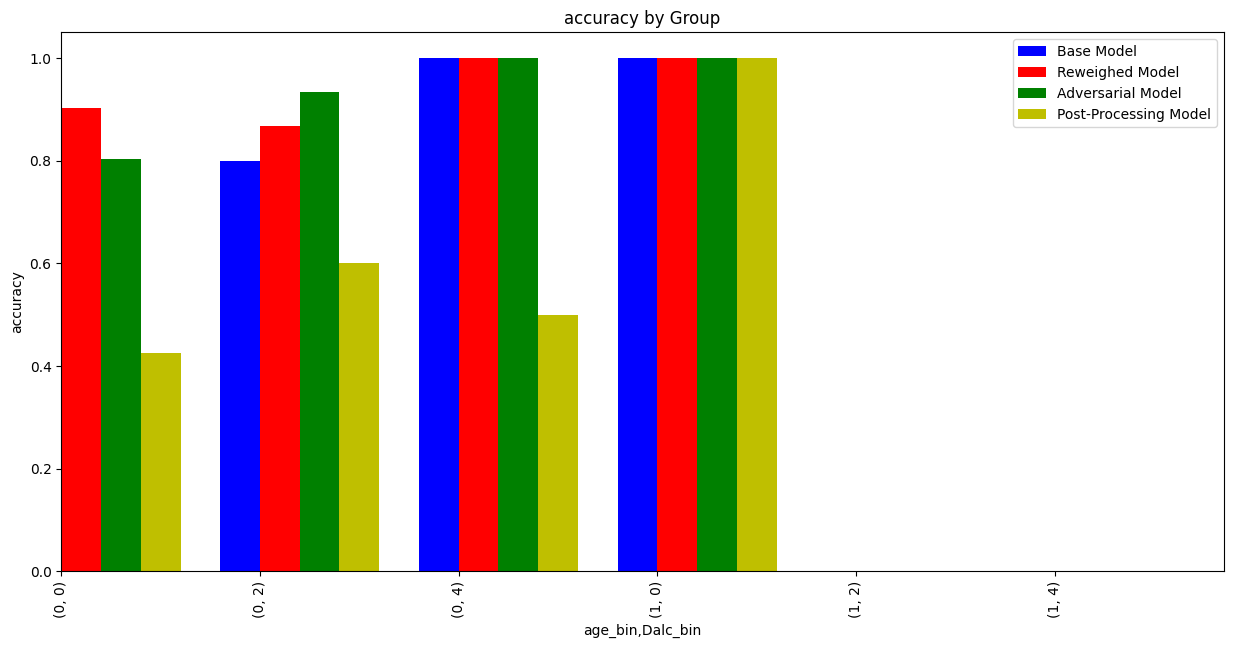

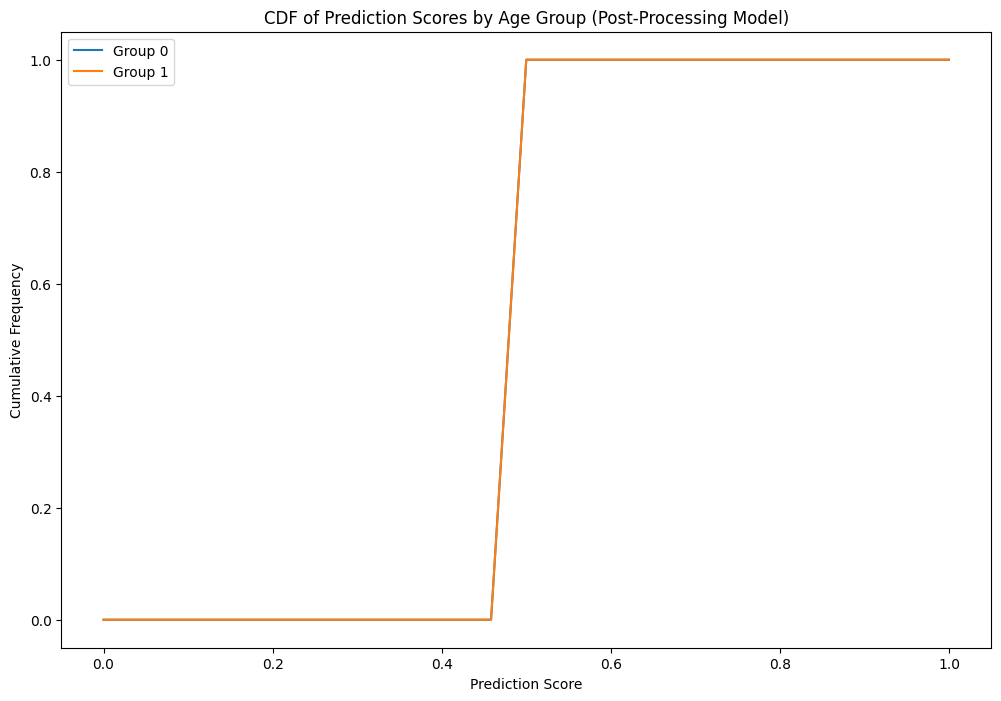

In [8]:
# Additional Visualization Functions

# Extract metrics by group for all models
metrics_by_group_base = metrics_base.by_group.apply(pd.Series)
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
metrics_by_group_adv = metrics_adv.by_group.apply(pd.Series)
metrics_by_group_post_proc = metrics_post_proc.by_group.apply(pd.Series)


def plot_disparity(metric, metric_base, metric_rw, metric_adv, metric_post_proc):
    fig, ax = plt.subplots(figsize=(15, 7))
    width = 0.2
    
    metric_base.plot(kind='bar', width=width, position=1, label='Base Model', ax=ax, color='b')
    metric_rw.plot(kind='bar', width=width, position=0, label='Reweighed Model', ax=ax, color='r')
    metric_adv.plot(kind='bar', width=width, position=-1, label='Adversarial Model', ax=ax, color='g')
    metric_post_proc.plot(kind='bar', width=width, position=-2, label='Post-Processing Model', ax=ax, color='y')
    
    plt.title(f'{metric} by Group')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

# Example usage for accuracy
plot_disparity('accuracy', metrics_by_group_base['accuracy'], metrics_by_group_rw['accuracy'], metrics_by_group_adv['accuracy'], metrics_by_group_post_proc['accuracy'])


def plot_cdf(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    plt.figure(figsize=(12, 8))
    
    for name, group in groups:
        y_pred_group = y_pred[group.index]
        ecdf = stats.cumfreq(y_pred_group, numbins=25)
        x = ecdf.lowerlimit + np.linspace(0, ecdf.binsize*ecdf.cumcount.size, ecdf.cumcount.size)
        plt.plot(x, ecdf.cumcount / ecdf.cumcount.max(), label=f'Group {name}')
    
    plt.title(title)
    plt.xlabel('Prediction Score')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.show()

# Example usage for post-processed model
plot_cdf(y_test, y_pred_post_proc, data.loc[X_test.index, 'age_bin'], 'CDF of Prediction Scores by Age Group (Post-Processing Model)')



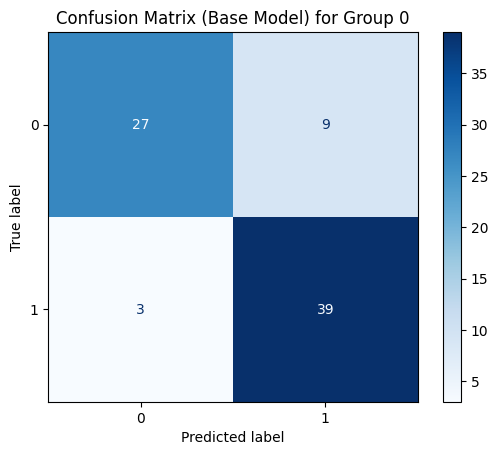

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


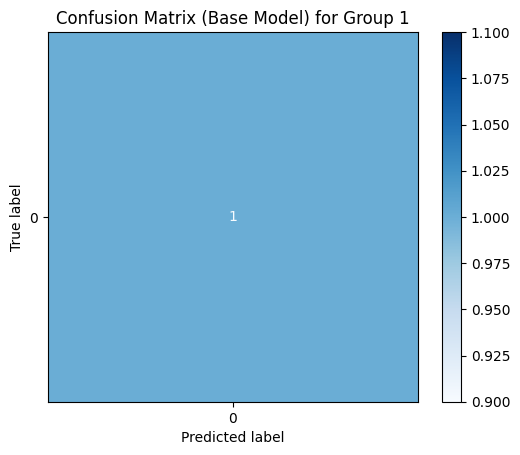

Overall Performance Metrics:
                       accuracy  precision    recall        f1
Base Model             0.848101   0.812500  0.928571  0.866667
Reweighed Model        0.898734   0.840000  1.000000  0.913043
Adversarial Model      0.835443   0.795918  0.928571  0.857143
Post-Processing Model  0.468354   0.000000  0.000000  0.000000


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


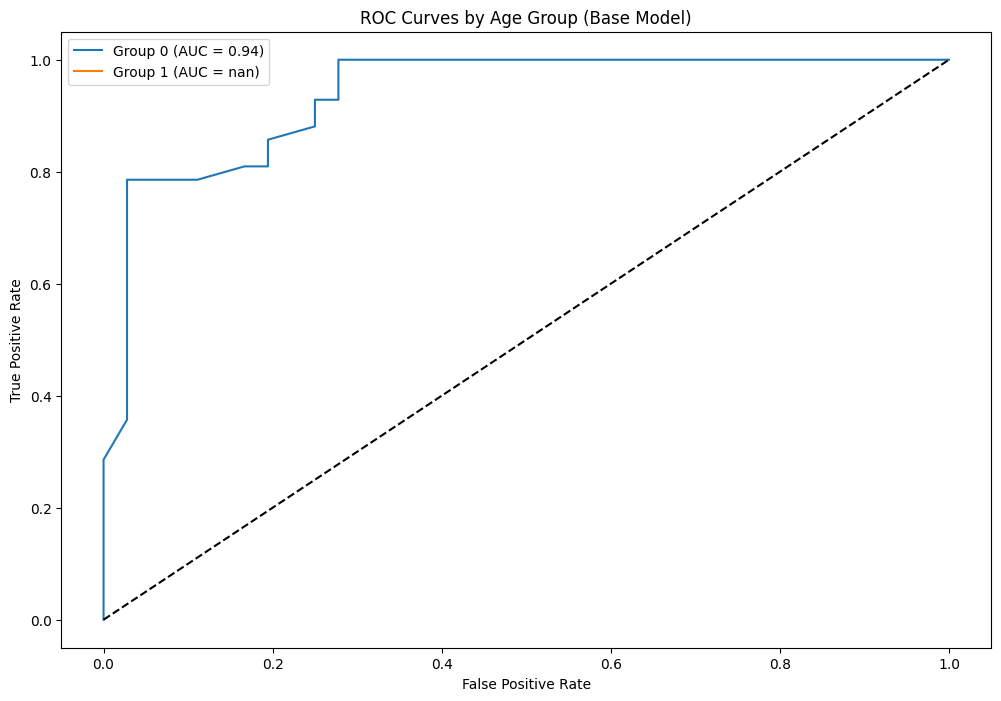

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_by_group(y_true, y_pred, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    
    for name, group in groups:
        cm = confusion_matrix(group, y_pred[group.index])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'{title} for Group {name}')
        plt.show()

# Example usage for base model
plot_confusion_matrix_by_group(y_test, y_pred_binary, data.loc[X_test.index, 'age_bin'], 'Confusion Matrix (Base Model)')


def model_performance_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

performance_base = model_performance_metrics(y_test, y_pred_binary)
performance_rw = model_performance_metrics(y_test, y_pred_binary_rw)
performance_adv = model_performance_metrics(y_test, y_pred_adv)
performance_post_proc = model_performance_metrics(y_test, y_pred_post_proc)

performance_df = pd.DataFrame([performance_base, performance_rw, performance_adv, performance_post_proc],
                              index=['Base Model', 'Reweighed Model', 'Adversarial Model', 'Post-Processing Model'])

print("Overall Performance Metrics:")
print(performance_df)


def plot_roc_by_group(y_true, y_pred_proba, sensitive_feature, title):
    groups = y_true.groupby(sensitive_feature)
    plt.figure(figsize=(12, 8))
    
    for name, group in groups:
        fpr, tpr, _ = roc_curve(group, y_pred_proba[group.index])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Group {name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Example usage for post-processed model
plot_roc_by_group(y_test, rf_model.predict_proba(X_test)[:, 1], data.loc[X_test.index, 'age_bin'], 'ROC Curves by Age Group (Base Model)')



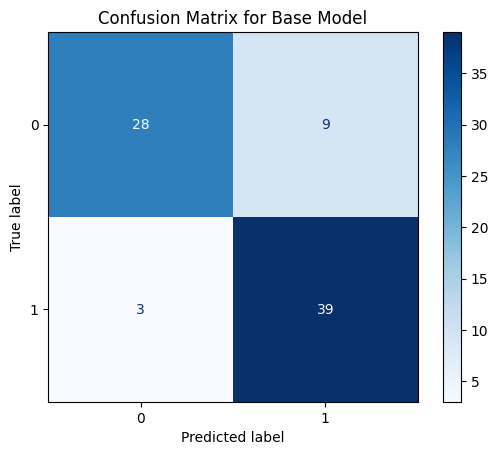

Base Model Metrics:
Accuracy: 0.8481
Precision: 0.8125
Recall: 0.9286
F1: 0.8667


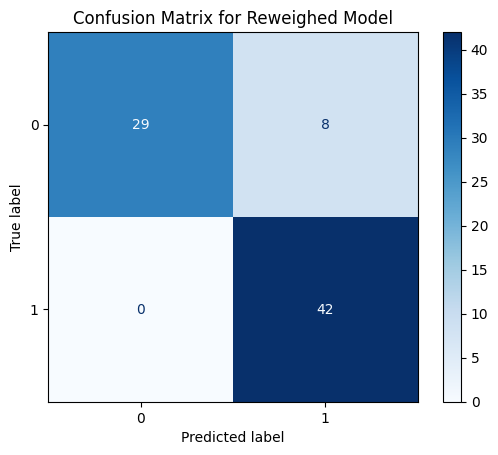

Reweighed Model Metrics:
Accuracy: 0.8987
Precision: 0.8400
Recall: 1.0000
F1: 0.9130


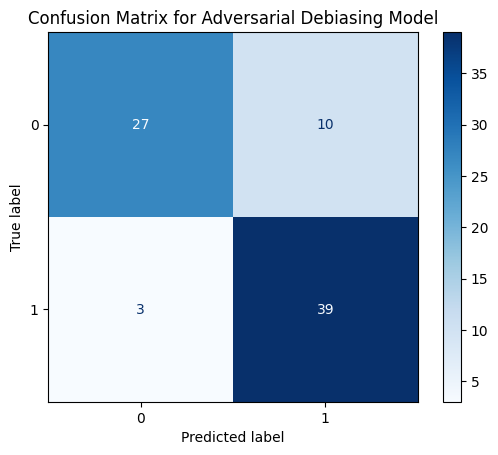

Adversarial Debiasing Model Metrics:
Accuracy: 0.8354
Precision: 0.7959
Recall: 0.9286
F1: 0.8571


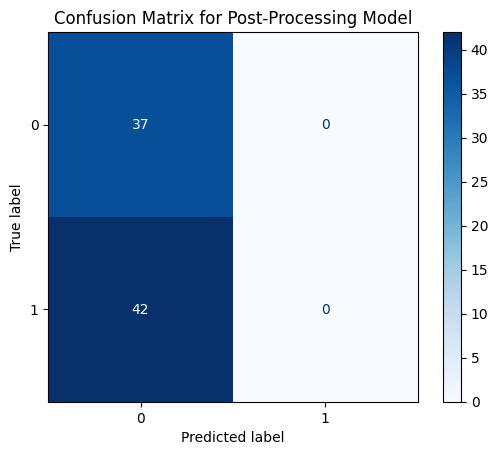

Post-Processing Model Metrics:
Accuracy: 0.4684
Precision: 0.0000
Recall: 0.0000
F1: 0.0000


In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

# Function to plot confusion matrix with metrics
def plot_confusion_matrix_with_metrics(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

    print(f"{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

# Plot confusion matrices with metrics for each model
plot_confusion_matrix_with_metrics(y_test, y_pred_binary, "Base Model")
plot_confusion_matrix_with_metrics(y_test, y_pred_binary_rw, "Reweighed Model")
plot_confusion_matrix_with_metrics(y_test, y_pred_adv, "Adversarial Debiasing Model")
plot_confusion_matrix_with_metrics(y_test, y_pred_post_proc, "Post-Processing Model")



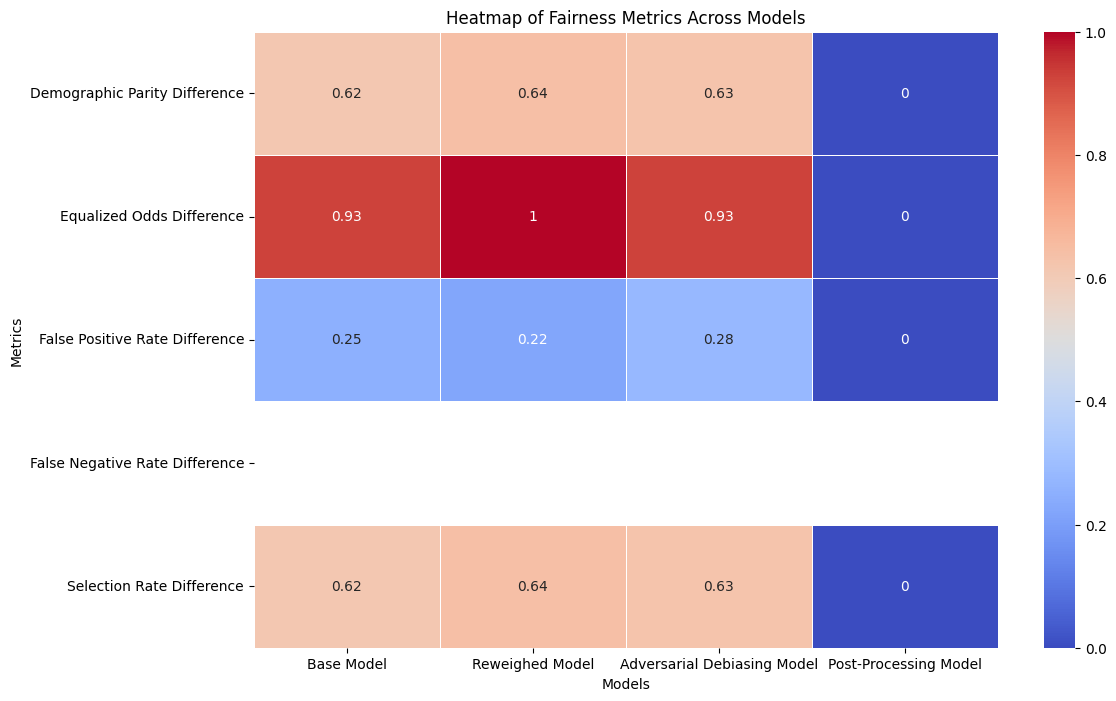

In [11]:
# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    'Base Model': [dpd_base, eod_base, fprd_base, fnrd_base, srd_base],
    'Reweighed Model': [dpd_rw, eod_rw, fprd_rw, fnrd_rw, srd_rw],
    'Adversarial Debiasing Model': [dpd_adv, eod_adv, fprd_adv, fnrd_adv, srd_adv],
    'Post-Processing Model': [dpd_post_proc, eod_post_proc, fprd_post_proc, fnrd_post_proc, srd_post_proc]
}, index=['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Fairness Metrics Across Models')
plt.ylabel('Metrics')
plt.xlabel('Models')
plt.show()

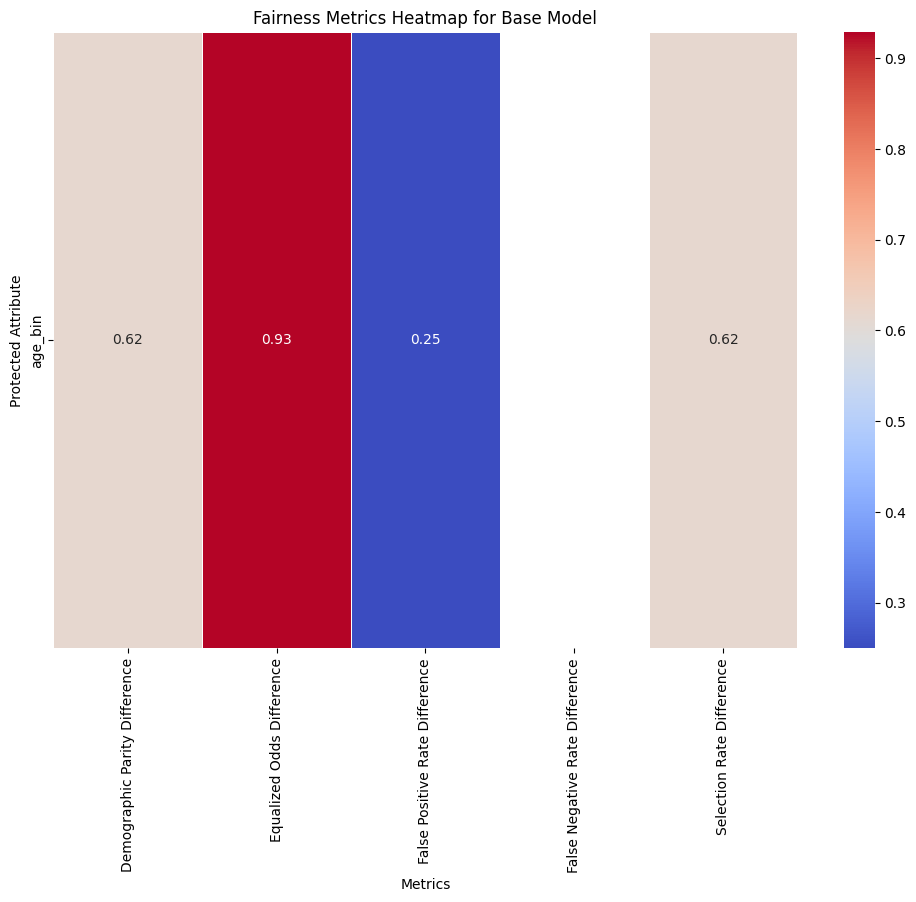

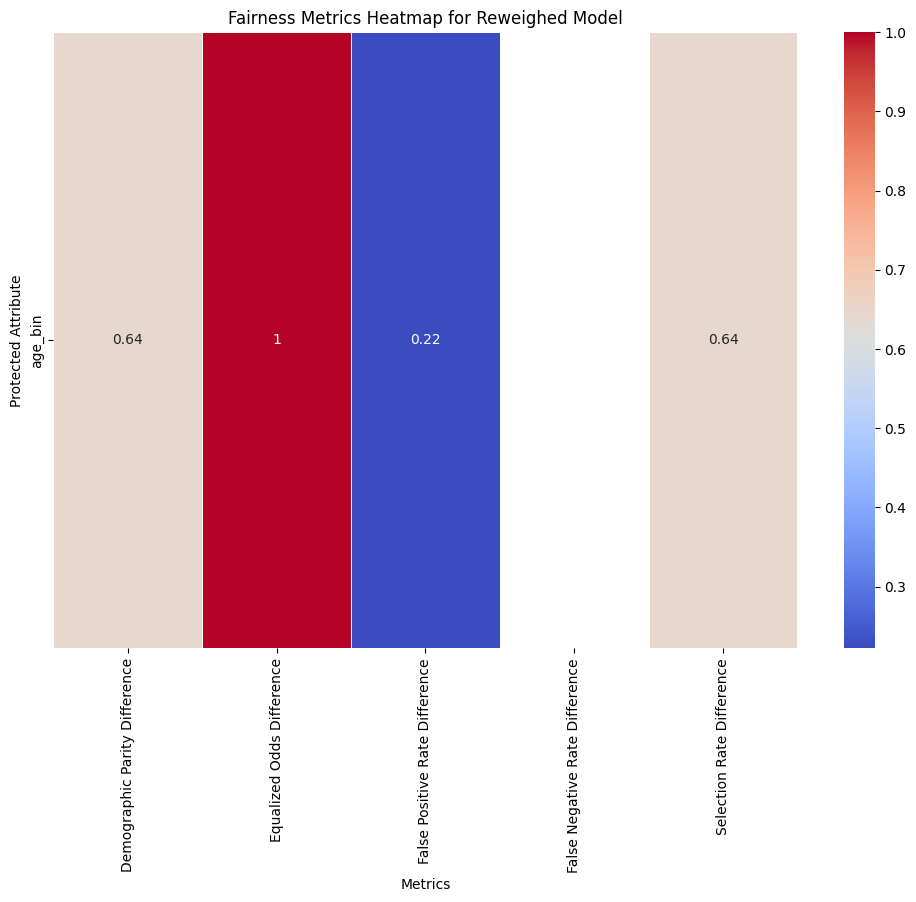

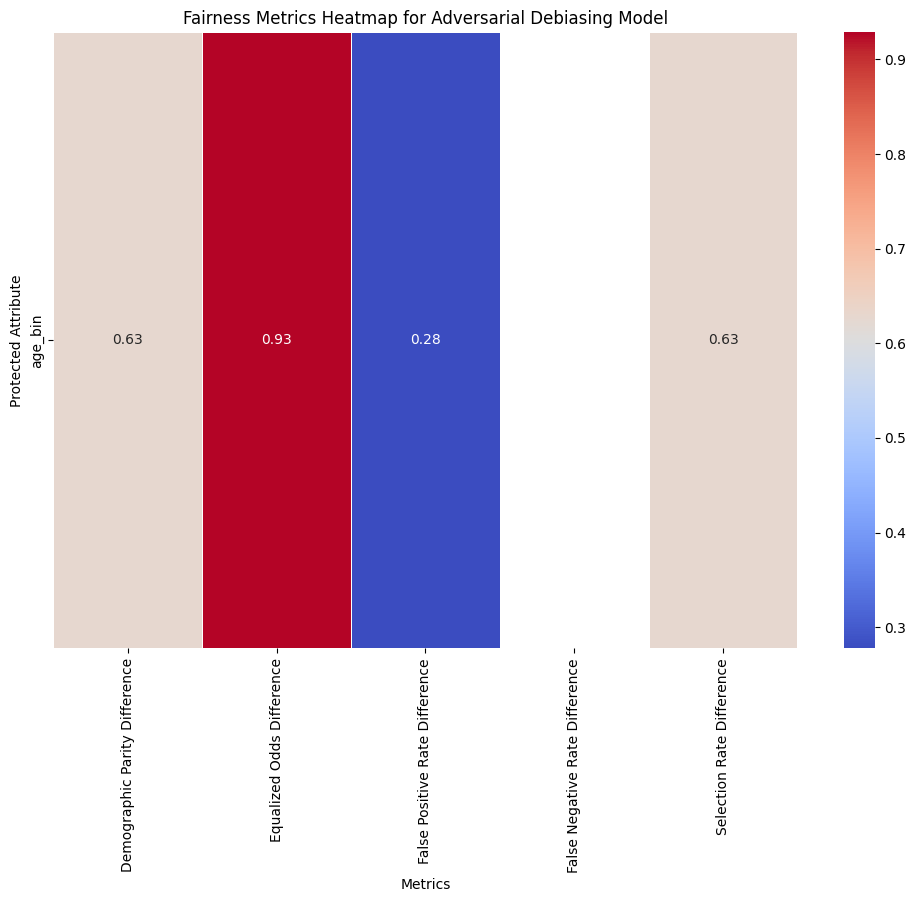

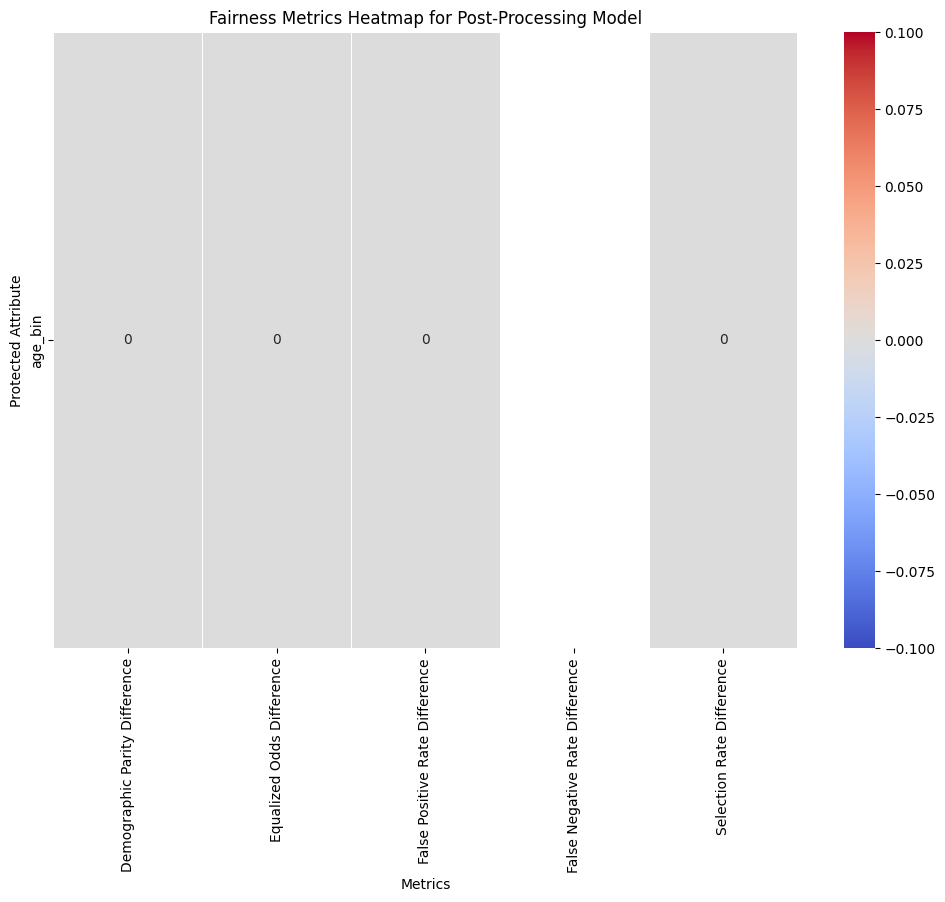

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap for fairness metrics of the base model
metrics_heatmap_base_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd_base],
    'Equalized Odds Difference': [eod_base],
    'False Positive Rate Difference': [fprd_base],
    'False Negative Rate Difference': [fnrd_base],
    'Selection Rate Difference': [srd_base]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_base_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Base Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Create heatmap for fairness metrics of the reweighed model
metrics_heatmap_rw_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd_rw],
    'Equalized Odds Difference': [eod_rw],
    'False Positive Rate Difference': [fprd_rw],
    'False Negative Rate Difference': [fnrd_rw],
    'Selection Rate Difference': [srd_rw]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_rw_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Reweighed Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Create heatmap for fairness metrics of the adversarial debiasing model
metrics_heatmap_adv_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd_adv],
    'Equalized Odds Difference': [eod_adv],
    'False Positive Rate Difference': [fprd_adv],
    'False Negative Rate Difference': [fnrd_adv],
    'Selection Rate Difference': [srd_adv]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_adv_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Adversarial Debiasing Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Create heatmap for fairness metrics of the post-processing model
metrics_heatmap_post_proc_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd_post_proc],
    'Equalized Odds Difference': [eod_post_proc],
    'False Positive Rate Difference': [fprd_post_proc],
    'False Negative Rate Difference': [fnrd_post_proc],
    'Selection Rate Difference': [srd_post_proc]
}, index=['age_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_post_proc_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap for Post-Processing Model')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()


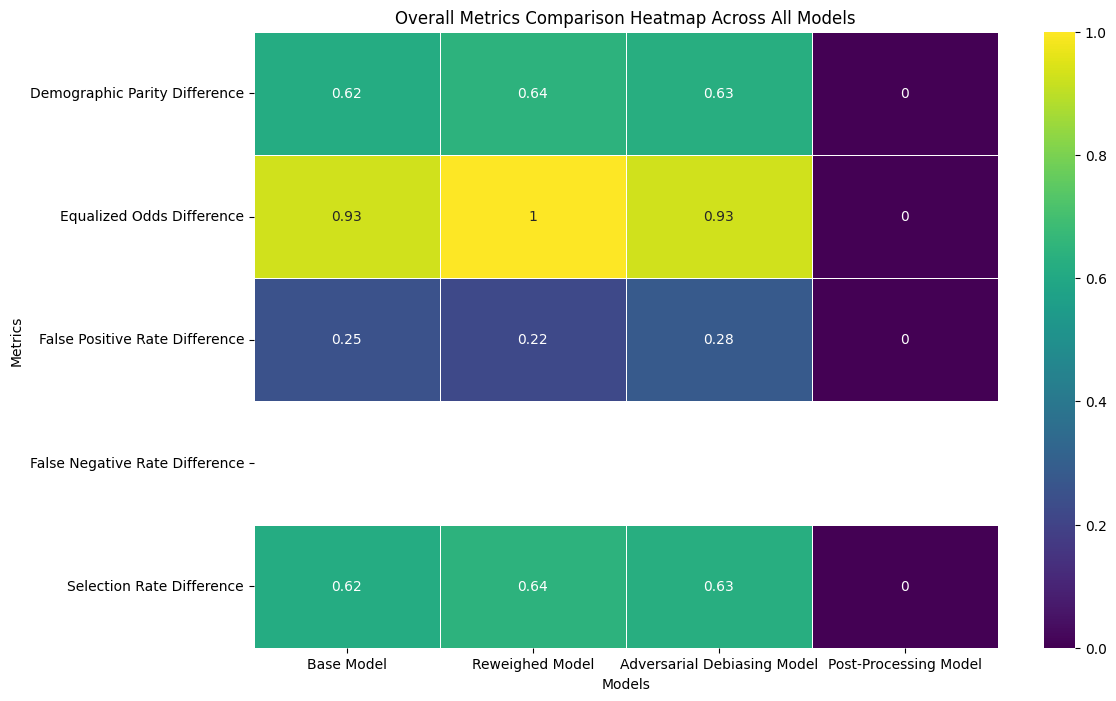

In [13]:
# Comparison heatmap for overall metrics across all models
comparison_heatmap_data = pd.DataFrame({
    'Base Model': [dpd_base, eod_base, fprd_base, fnrd_base, srd_base],
    'Reweighed Model': [dpd_rw, eod_rw, fprd_rw, fnrd_rw, srd_rw],
    'Adversarial Debiasing Model': [dpd_adv, eod_adv, fprd_adv, fnrd_adv, srd_adv],
    'Post-Processing Model': [dpd_post_proc, eod_post_proc, fprd_post_proc, fnrd_post_proc, srd_post_proc]
}, index=['Demographic Parity Difference', 'Equalized Odds Difference', 'False Positive Rate Difference', 'False Negative Rate Difference', 'Selection Rate Difference'])

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap Across All Models')
plt.ylabel('Metrics')
plt.xlabel('Models')
plt.show()
